In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

from utils.dataloader  import FaceDataset, preprocess, postprocess
from utils.utils_data import train_validation_test_split

### Telechargement et Visualisation de notre jeu de donnée

In [2]:
faceDataset = FaceDataset(preprocess(), is_classification=True)
print(f'Taille du dataset: {len(faceDataset)}')

Taille du dataset: 43266


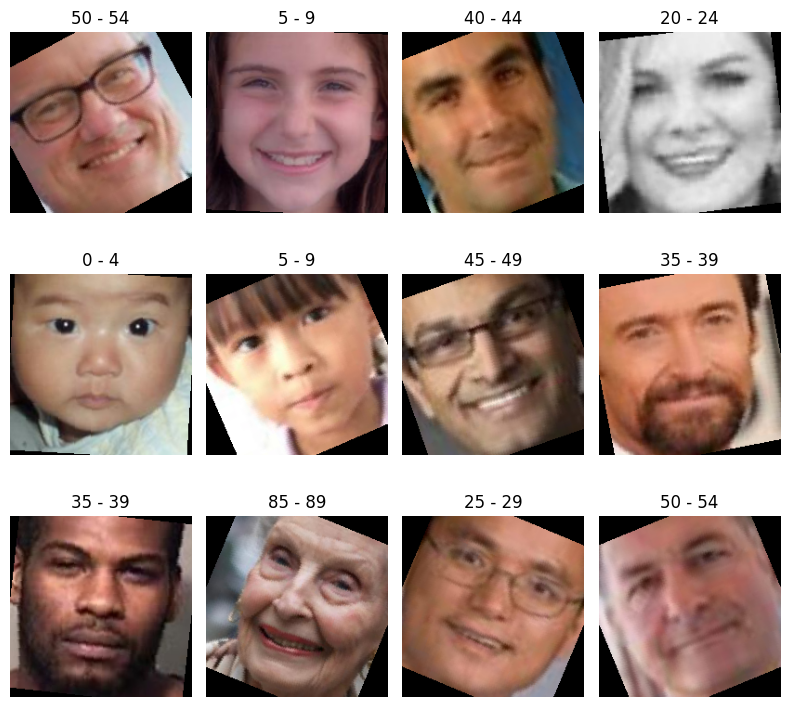

In [3]:
fig, ax = plt.subplots(3, 4, tight_layout=True, figsize=(8, 8))

label_names = faceDataset.get_all_age_range()

for i in range(3):
    for j in range(4):
        rand_idx = np.random.randint(0, len(faceDataset))
        img, label = faceDataset[rand_idx]
        postprocess_apply = postprocess()
        ax[i,j].imshow(postprocess_apply(img))
        ax[i,j].set_title(label_names[label])
        ax[i,j].set_axis_off()
        

##### Visualisation de la distribution des données

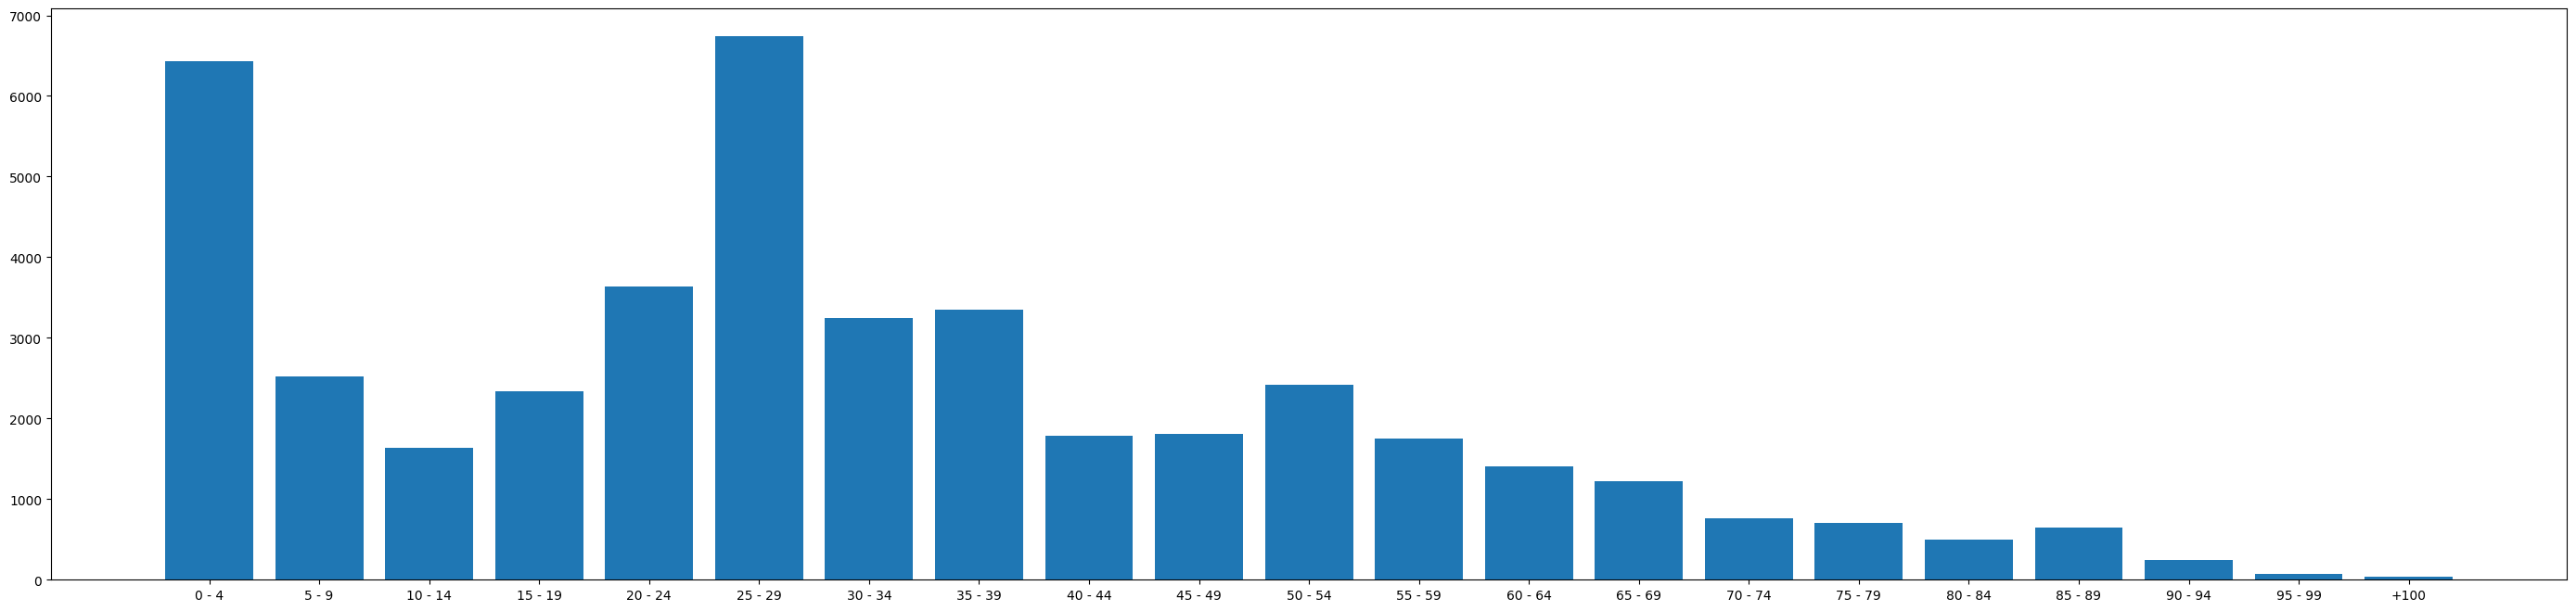

In [4]:
img_by_age_range = faceDataset.img_labels.groupby(['age_range'])['age_range']
df = img_by_age_range.count()

fig, ax = plt.subplots(figsize=(35, 8))
bar_container = ax.bar(label_names.values(), df.values)


In [44]:
import torch
import torch.nn as nn
import torchvision.models as models

# Charger le modèle Swin Transformer préentraîné sur ImageNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)

# Changer la dernière couche pour qu'elle corresponde au nombre de classes de notre tâche
num_classes = 21
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)

print(model)

freez = ['head.weight', 'head.bias', 'norm.weight', 'norm.bias']

for name, param in model.named_parameters():
    if name not in freez:
        param.requires_grad = False


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [7]:
train_sampler, validation_sampler, test_sampler = train_validation_test_split(faceDataset,validation_size=0.1, test_size=0.2)
batch_size = 16
# Charger les données d'entraînement et de validation


In [12]:
train_loader = torch.utils.data.DataLoader(faceDataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(faceDataset, batch_size=batch_size, sampler=test_sampler)


In [45]:
# Définir la fonction de coût et l'optimiseur
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005,)

# Fine-tuner le modèle
num_epochs = 10
for epoch in range(num_epochs):
    model.to(device)
    # Entraînement
    model.train()
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Évaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
    # Afficher les résultats de l'époque
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

100%|██████████| 1947/1947 [02:02<00:00, 15.90it/s]


Epoch [1/10], Loss: 2.4583, Accuracy: 35.79%


100%|██████████| 1947/1947 [02:02<00:00, 15.94it/s]


Epoch [2/10], Loss: 2.2834, Accuracy: 37.24%


100%|██████████| 1947/1947 [03:07<00:00, 10.37it/s]


Epoch [3/10], Loss: 1.6890, Accuracy: 36.97%


100%|██████████| 1947/1947 [02:14<00:00, 14.50it/s]


Epoch [4/10], Loss: 1.3410, Accuracy: 37.20%


100%|██████████| 1947/1947 [02:02<00:00, 15.92it/s]


Epoch [5/10], Loss: 2.2565, Accuracy: 36.70%


100%|██████████| 1947/1947 [02:01<00:00, 16.06it/s]


Epoch [6/10], Loss: 1.4873, Accuracy: 38.16%


100%|██████████| 1947/1947 [02:00<00:00, 16.10it/s]


Epoch [7/10], Loss: 1.7949, Accuracy: 36.83%


100%|██████████| 1947/1947 [02:04<00:00, 15.70it/s]


Epoch [8/10], Loss: 2.3186, Accuracy: 37.89%


100%|██████████| 1947/1947 [02:01<00:00, 16.06it/s]


Epoch [9/10], Loss: 1.8483, Accuracy: 37.63%


 36%|███▌      | 705/1947 [00:44<01:18, 15.73it/s]


KeyboardInterrupt: 

In [ ]:
# Charger le modèle Swin Transformer préentraîné sur ImageNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)

# Changer la dernière couche pour qu'elle corresponde au nombre de classes de notre tâche
num_classes = 1
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)

print(model)

freez = ['head.weight', 'head.bias', 'norm.weight', 'norm.bias']

for name, param in model.named_parameters():
    if name not in freez:
        param.requires_grad = False

In [ ]:
# Définir la fonction de coût et l'optimiseur
from tqdm import tqdm
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005,)

# Fine-tuner le modèle
num_epochs = 10
for epoch in range(num_epochs):
    model.to(device)
    # Entraînement
    model.train()
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Évaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
    # Afficher les résultats de l'époque
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')